# Defining multimorbidity using graph-based approaches in a clinical population

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In order to run this code, you need to have access to MIMIC-III dataset. 
You can request access to the dataset here: https://mimic.physionet.org/gettingstarted/access/.

You have 2 options to run the dataset:

Either from Google Cloud Platform (GCP) or from your local machine.

In our case scenario we don't need to use the full dataset and we are lucky enough our local machine can handle the dataset.

## Data Imports

In [70]:
paths = {
    'patients': 'database/PATIENTS.csv.gz',
    'admissions': 'database/ADMISSIONS.csv.gz',
    'diagnoses_icd': 'database/DIAGNOSES_ICD.csv.gz',
    'd_icd_diagnoses': 'database/D_ICD_DIAGNOSES.csv.gz',
}

patients_df = pd.read_csv(paths['patients'], compression='gzip')
admissions_df = pd.read_csv(paths['admissions'], compression='gzip')
diagnoses_icd_df = pd.read_csv(paths['diagnoses_icd'], compression='gzip')
d_icd_diagnoses_df = pd.read_csv(paths['d_icd_diagnoses'], compression='gzip')

## Functions

In [71]:
def value_counts_with_percentage(series):
    value_counts = series.value_counts()

    percentages = value_counts / len(series) * 100

    result_df = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages
    })

    na_count = series.isna().sum()
    if na_count > 0:
        na_row = pd.DataFrame({'Count': [na_count], 'Percentage': na_count / len(series) * 100}, index=['NA'])
        result_df = pd.concat([na_row, result_df])


    result_df['Percentage'] = result_df['Percentage'].map('{:.2f}%'.format)

    total_count = series.count() + na_count
    total_row = pd.DataFrame({'Count': [total_count], 'Percentage': ''}, index=['Total'])
    result_df = pd.concat([result_df, total_row])

    return result_df

## Dataset Exploration

### MIMIC-III Database

Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. W. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Anthony Celi, L., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3. https://doi.org/10.1038/sdata.2016.35

### Patients Table

`subject_id` : unique identifier for patients

`gender` : gender of the patient

`dob` : date of birth

`dod` : date of death <br>
If NULL the patient was alive at the time of database creation.

`dod_hosp` : date of death in the hospital <br>
If NULL the patient did not die in the hospital.

`dod_ssn` : date of death as recorded by the Social Security Administration.

`expire_flag` : in-hospital mortality <br>
1 if the patient died in the hospital <br>
0 otherwise

In [72]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [73]:
print('Number of unique patients:', len(patients_df))

Number of unique patients: 46520


In [74]:
value_counts_with_percentage(patients_df['GENDER'])

,Count,Percentage
M,26121,56.15%
F,20399,43.85%
Total,46520,


In [1]:
#toDO count expire_flag

### Admissions Table

`row_id` : unique identifier for each row

`subject_id` :  patient id

`hadm_id` : unique identifier for each admission

`admittime` : datetime for patient admission

`dischtime` : datetime for patient discharge

`deathtime` : datetime of patient death, if applicable

`admission_type` : type of admission

`admission_location` : location from which the patient was admitted

`discharge_location` : location to which the patient was discharged

`insurance` : primary insurance provider

`language` : primary language of the patient

`religion` : religion of the patient

`marital_status` : marital status of the patient

`ethnicity` : ethnicity of the patient

`edregtime` : datetime of patient registration in the emergency department

`edouttime` : datetime of patient discharge from the emergency department

`diagnosis` : free-text field containing the diagnosis at the time of admission

`hospital_expire_flag` : indicator of in-hospital mortality <br>
1 if the patient died in the hospital during this admission <br>
0 otherwise

`has_chartevents_data` : indicator of whether there is data available in the chartevents table for this admission <br>
1 if data is available <br>
0 otherwise

In [76]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [77]:
print('Number of unique admissions:', len(admissions_df))

Number of unique admissions: 58976


In [78]:
value_counts_with_percentage(admissions_df['ADMISSION_TYPE'])

,Count,Percentage
EMERGENCY,42071,71.34%
NEWBORN,7863,13.33%
ELECTIVE,7706,13.07%
URGENT,1336,2.27%
Total,58976,


In [79]:
value_counts_with_percentage(admissions_df['ADMISSION_LOCATION'])

,Count,Percentage
EMERGENCY ROOM ADMIT,22754,38.58%
PHYS REFERRAL/NORMAL DELI,15079,25.57%
CLINIC REFERRAL/PREMATURE,12032,20.40%
TRANSFER FROM HOSP/EXTRAM,8456,14.34%
TRANSFER FROM SKILLED NUR,273,0.46%
** INFO NOT AVAILABLE **,204,0.35%
HMO REFERRAL/SICK,102,0.17%
TRANSFER FROM OTHER HEALT,71,0.12%
TRSF WITHIN THIS FACILITY,5,0.01%
Total,58976,


Maybe we will exclude rows with admission type NEWBORN as it is not a disease and the MIMIC Dataset dont have pediatric data , it has only have newborns.

In [80]:
value_counts_with_percentage(admissions_df['INSURANCE'])

,Count,Percentage
Medicare,28215,47.84%
Private,22582,38.29%
Medicaid,5785,9.81%
Government,1783,3.02%
Self Pay,611,1.04%
Total,58976,


In [81]:
value_counts_with_percentage(admissions_df['MARITAL_STATUS'])

,Count,Percentage
NA,10128,17.17%
MARRIED,24239,41.10%
SINGLE,13254,22.47%
WIDOWED,7211,12.23%
DIVORCED,3213,5.45%
SEPARATED,571,0.97%
UNKNOWN (DEFAULT),345,0.58%
LIFE PARTNER,15,0.03%
Total,58976,


In [82]:
value_counts_with_percentage(admissions_df['ETHNICITY']).head(10)

,Count,Percentage
WHITE,40996,69.51%
BLACK/AFRICAN AMERICAN,5440,9.22%
UNKNOWN/NOT SPECIFIED,4523,7.67%
HISPANIC OR LATINO,1696,2.88%
OTHER,1512,2.56%
ASIAN,1509,2.56%
UNABLE TO OBTAIN,814,1.38%
PATIENT DECLINED TO ANSWER,559,0.95%
ASIAN - CHINESE,277,0.47%
HISPANIC/LATINO - PUERTO RICAN,232,0.39%


In [83]:
#toDO count deaths in hospital

### ICD-9 Diagnosis Codes

`row_id` : unique identifier for each row 

`subject_id` : unique identifier for patient

`hadm_id` : unique identifier for hospital admission

`seq_num` : indicating the order of diagnoses for a admission

`icd9_code` : ICD-9 code for the diagnosis

In [84]:
diagnoses_icd_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [85]:
# unique ICD9_CODE
print('Number of unique ICD9_CODE:', len(diagnoses_icd_df['ICD9_CODE'].unique()))

Number of unique ICD9_CODE: 6985


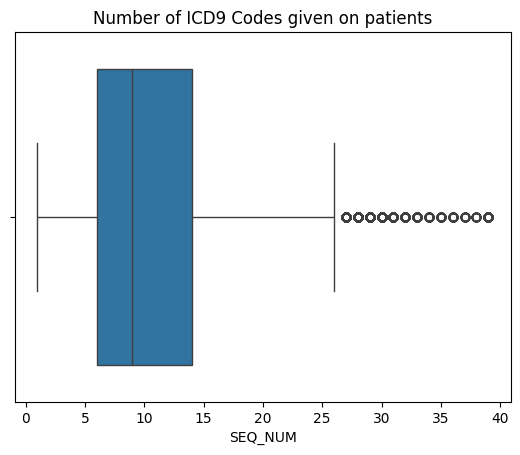

In [86]:
import seaborn as sns
# seq_num describe grouped by subject_id and keeping the max value of seq_num
# checking how many icd9_code on average the doctors are using
x = diagnoses_icd_df.groupby('SUBJECT_ID')['SEQ_NUM'].max()
sns.boxplot(x, orient='h')
plt.title('Number of ICD9 Codes given on patients')
plt.show()

seems the most usual number of ICD9 codes given in the hospital are arround 5-15 with most of them around 10

In [87]:
diagnoses_icd_df.merge(d_icd_diagnoses_df, on='ICD9_CODE').groupby(['ICD9_CODE','SHORT_TITLE'])['SUBJECT_ID'].count().sort_values(ascending=False).head(10)
#QA In aritcle

ICD9_CODE  SHORT_TITLE             
4019       Hypertension NOS            20703
4280       CHF NOS                     13111
42731      Atrial fibrillation         12891
41401      Crnry athrscl natve vssl    12429
5849       Acute kidney failure NOS     9119
25000      DMII wo cmp nt st uncntr     9058
2724       Hyperlipidemia NEC/NOS       8690
51881      Acute respiratry failure     7497
5990       Urin tract infection NOS     6555
53081      Esophageal reflux            6326
Name: SUBJECT_ID, dtype: int64

Zhao, B., Huepenbecker, S., Zhu, G., Rajan, S. S., Fujimoto, K., & Luo, X. (2023). Comorbidity network analysis using graphical models for electronic health records. Frontiers in Big Data, 6. https://doi.org/10.3389/fdata.2023.846202

>QA: In this article they have removed the most infrequent cases. Are we going to do the same ?

 The format for ICD-9 diagnoses codes is a decimal placed after the first three characters and two possible add-on characters following: xxx.xx

Except those which they start with letter 'E'. These codes are in the format Exxx.x

In the Data preparation section we will add '.' to the ICD-9 codes. The main reason is that we want to have the option to run the model with the first 3 characters of the ICD-9 codes and be able to use subcategories for these.

>QA: Are we going to use the subcategories for the ICD-9 codes? Where to find them? In the above article they also used subcategories of 3-digit ICD9 for the CNA

In [88]:
# Checking if ICD9_CODE is unique
d_icd_diagnoses_df['ICD9_CODE'].is_unique

True

In [89]:
print('Number of unique ICD9 codes:', len(d_icd_diagnoses_df))

Number of unique ICD9 codes: 14567


In [90]:
#filter rows that the ICD9_CODE is 3 digit 
d_icd_diagnoses_df['ICD9_CODE'].str[:3].unique().__len__()

1042

### More Complex Queries

let's join Patients and Admissions , in order to take the ages of the patients

In [91]:
df_merge_patients_admission = pd.merge(patients_df, admissions_df, on='SUBJECT_ID', how='inner')

<Axes: title={'center': 'Number of admissions per patient'}, xlabel='count', ylabel='Count'>

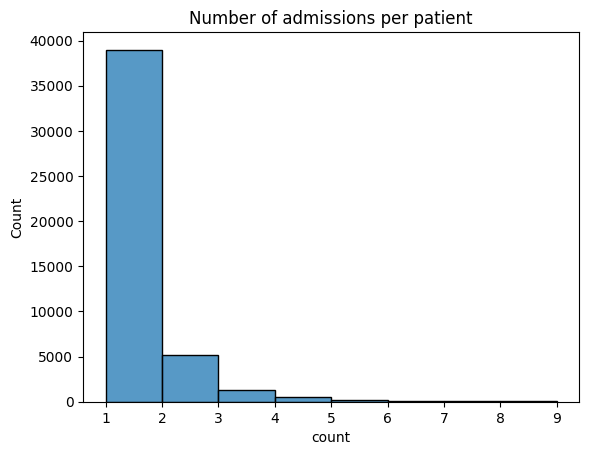

In [92]:
#count admissions per patient
plt.title('Number of admissions per patient')
sns.histplot(df_merge_patients_admission['SUBJECT_ID'].value_counts(), bins=range(1, 10))

seems that most patients have only one admission and the number of patients with more than one admission decreases exponentially

In [93]:
#age of patients
# calculating age, because MIMIC-3 Dataset swiufted the age of birth. We are going to do DOB - ADMITTIME to calculate the age
df_merge_patients_admission['AGE'] = (pd.to_datetime(df_merge_patients_admission['ADMITTIME']).dt.date - pd.to_datetime(df_merge_patients_admission['DOB']).dt.date).apply(lambda x: x.days)//365

<Axes: xlabel='AGE', ylabel='Count'>

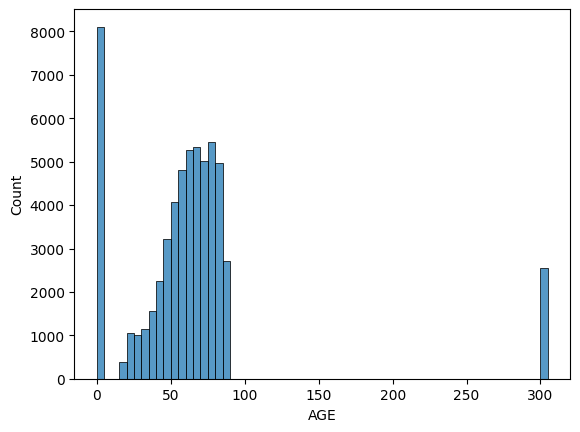

In [94]:
#that's not correct because the patient can have more than one admission, so we take some diffent age from the same patient
#but we just want to know about outliers and the data we have for now.
#we will decide later what we will do with the many admission for each patient. Maybe we wil keep the last one
sns.histplot(df_merge_patients_admission['AGE'], bins=range(0, 310, 5))

In [95]:
#make 7 groups of age, age 0, 1-17, 18-39, 40-60, 61-89, 90-299, 300
bins = [-0.1, 1, 17, 39, 60, 89, 299, 300]
labels = ['0', '1-17', '18-39', '40-60', '61-89', '90-299', '300']

df_merge_patients_admission['AGE_GROUP'] = pd.cut(df_merge_patients_admission['AGE'], bins=bins, labels=labels)
df_merge_patients_admission['AGE_GROUP'].value_counts()

AGE_GROUP
61-89     27731
40-60     15368
0          8110
18-39      5051
300        2245
1-17        100
90-299        0
Name: count, dtype: int64

Summary of data exploration:

- We have 46520 patients and 58976 admissions
- The average age of the patients is 65 years old without filtering the newborns, ages that are 300 and the last encounter for each patient
- The most patients have 1 admission and the number of patients with more than one admission decreases exponentially
- The most usual number of ICD9 codes given in the hospital are arround 5-15 with most of them around 10
- ICD9 codes are in the format xxxxx and Exxxx, we need to manipulate them to have the format xxx.xx and Exxx.x
- We have 6984 unique ICD9 codes in admissions  

## Webscrapping ICD-9 Codes Subcategories 

in the article they used the subcategories of the ICD-9 codes, we need to find them and add them to our dataset.

We are going to use the following website to get the subcategories of the ICD-9 codes: https://www.icd9data.com/
and make a web scrapper in order to get them. You can find the code in the file `icd9_scrapper.py`

In [96]:
dtype_dict = {
    'level1_code': str,
    'level1_description': str,
    'level2_code': str,
    'level2_description': str,
    'level3_code': str,
    'level3_description': str,
    'level4_code': str,
    'level4_description': str,
    'level5_code': str,
    'level5_description': str
}
icd9_imported_categories = pd.read_csv('icd9-categories.csv', dtype=dtype_dict)

In [97]:
len(icd9_imported_categories)

16456

In [98]:
icd9_imported_categories['level1_code'].value_counts().sort_index()

level1_code
001-139      1405
140-239      1069
240-279       383
280-289       138
290-319       559
320-389      1649
390-459       556
460-519       287
520-579       712
580-629       429
630-679      1407
680-709       223
710-739       997
740-759       480
760-779       303
780-799       424
800-999      2876
E000-E999    1291
V01-V91      1268
Name: count, dtype: int64

In [99]:
icd9_imported_categories['level2_code'].unique().__len__()

156

In [100]:
icd9_imported_categories['level3_code'].unique().__len__()

1234

In [101]:
icd9_imported_categories['level4_code'].unique().__len__()

7988

In [102]:
icd9_imported_categories['level5_code'].unique().__len__()

16456

## Data Preparation

We are going to do the following:
1) Merge admissions and patients tables and keep only the last encounter in the hospital for each patient (the same as the article)
2) Filter out the newborns because they are not diseases
3) Add '.' to the ICD-9 codes and find a way to add subcategories, we need to find an external source for this
4) Exploration of data after the changes
5) Finally make tables Sparse Matrix tables, that columns will have the ICD-9 codes and the rows the last admission for each patient we kept in the dataset

>QA In the article they filter out most uncommon diseases, wanna do the same ?

### Keep Last Encounter for Each Patient

In [103]:
#we have already merged patients and admissions
#now we are going to keep the last admission of each patient
df_merge_patients_admission.sort_values(['SUBJECT_ID','ADMITTIME'], ascending=False, inplace=True)

In [104]:
#checking sorting if it's correct
#reminding that subject_id is the unique identifier of the patient
#also admittime is the time that the patient was admitted to the hospital
df_merge_patients_admission.loc[df_merge_patients_admission.duplicated('SUBJECT_ID', keep=False), ['SUBJECT_ID', 'ADMITTIME']].head(10)

,SUBJECT_ID,ADMITTIME
52352,99982,2157-02-16 17:31:00
52351,99982,2157-01-05 17:27:00
52350,99982,2156-11-28 11:56:00
51527,99923,2201-05-15 13:12:00
51526,99923,2201-02-23 20:42:00
51519,99897,2182-07-03 19:50:00
51518,99897,2181-08-06 02:22:00
51515,99883,2132-09-15 00:36:00
51514,99883,2131-12-24 17:41:00
50734,99822,2197-07-03 02:24:00


In [105]:
df_last_admission = df_merge_patients_admission.drop_duplicates('SUBJECT_ID', keep='first')

In [106]:
#if len of df_last_admission is equal to the number of unique patients, we have done it correctly
len(df_last_admission)

46520

### Filter Out Newborns

In [107]:
df_filtered_last_adm = df_last_admission.loc[df_last_admission['AGE'] > 17]
df_filtered_last_adm

,ROW_ID_x,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID_y,HADM_ID,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,AGE,AGE_GROUP
52358,46520,99999,F,2054-01-06 00:00:00,NaN,NaN,NaN,0,58976,113369,...,JEHOVAH'S WITNESS,SEPARATED,HISPANIC OR LATINO,NaN,NaN,SPONDYLOLISTHESIS/SDA,0,1,64,61-89
52357,46519,99995,F,2058-05-29 00:00:00,2147-09-29 00:00:00,NaN,2147-09-29 00:00:00,1,58975,137810,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,88,61-89
52356,46518,99992,F,2078-10-17 00:00:00,NaN,NaN,NaN,0,58974,197084,...,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,65,61-89
52355,46517,99991,M,2137-04-07 00:00:00,NaN,NaN,NaN,0,58973,151118,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,47,40-60
52354,46516,99985,M,2127-04-08 00:00:00,NaN,NaN,NaN,0,58972,176670,...,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,53,40-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,10,11,F,2128-02-22 00:00:00,2178-11-14 00:00:00,NaN,2178-11-14 00:00:00,1,10,194540,...,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1,50,40-60
305,8,9,M,2108-01-26 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,8,150750,...,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1,41,40-60
302,5,6,F,2109-06-21 00:00:00,NaN,NaN,NaN,0,5,107064,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,65,61-89
300,3,4,F,2143-05-12 00:00:00,NaN,NaN,NaN,0,3,185777,...,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,47,40-60


### Add imported ICD-9 Codes and Joins

In [108]:
icd9_imported_categories['lvel5_code_replaced_dot'] = icd9_imported_categories['level5_code'].str.replace('.', '')

In [109]:
icd9_imported_categories['lvel5_code_replaced_dot'].is_unique

True

In [110]:
icd9_imported_categories.merge(d_icd_diagnoses_df, left_on='lvel5_code_replaced_dot', right_on='ICD9_CODE', how='inner')

,level1_code,level1_description,level2_code,level2_description,level3_code,level3_description,level4_code,level4_description,level5_code,level5_description,lvel5_code_replaced_dot,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,001-139,Infectious And Parasitic Diseases,001-009,Intestinal Infectious Diseases,001,Cholera,001.0,Cholera due to vibrio cholerae,001.0,Cholera due to vibrio cholerae,0010,233,0010,Cholera d/t vib cholerae,Cholera due to vibrio cholerae
1,001-139,Infectious And Parasitic Diseases,001-009,Intestinal Infectious Diseases,001,Cholera,001.1,Cholera due to vibrio cholerae el tor,001.1,Cholera due to vibrio cholerae el tor,0011,234,0011,Cholera d/t vib el tor,Cholera due to vibrio cholerae el tor
2,001-139,Infectious And Parasitic Diseases,001-009,Intestinal Infectious Diseases,001,Cholera,001.9,"Cholera, unspecified",001.9,"Cholera, unspecified",0019,235,0019,Cholera NOS,"Cholera, unspecified"
3,001-139,Infectious And Parasitic Diseases,001-009,Intestinal Infectious Diseases,002,Typhoid and paratyphoid fevers,002.0,Typhoid fever,002.0,Typhoid fever,0020,236,0020,Typhoid fever,Typhoid fever
4,001-139,Infectious And Parasitic Diseases,001-009,Intestinal Infectious Diseases,002,Typhoid and paratyphoid fevers,002.1,Paratyphoid fever A,002.1,Paratyphoid fever A,0021,237,0021,Paratyphoid fever a,Paratyphoid fever A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562,740-759,Congenital Anomalies,740-759,Congenital Anomalies,759,Other and unspecified congenital anomalies,759.81,Prader-Willi syndrome,759.81,Prader-Willi syndrome,75981,7881,75981,Prader-willi syndrome,Prader-Willi syndrome
14563,740-759,Congenital Anomalies,740-759,Congenital Anomalies,759,Other and unspecified congenital anomalies,759.82,Marfan syndrome,759.82,Marfan syndrome,75982,7882,75982,Marfan syndrome,Marfan syndrome
14564,740-759,Congenital Anomalies,740-759,Congenital Anomalies,759,Other and unspecified congenital anomalies,759.83,Fragile X syndrome,759.83,Fragile X syndrome,75983,7883,75983,Fragile x syndrome,Fragile X syndrome
14565,740-759,Congenital Anomalies,740-759,Congenital Anomalies,759,Other and unspecified congenital anomalies,759.89,Other specified congenital anomalies,759.89,Other specified congenital anomalies,75989,7884,75989,Specfied cong anomal NEC,Other specified congenital anomalies


In [111]:
len(d_icd_diagnoses_df)

14567

In [112]:
df_merged_codes = d_icd_diagnoses_df.merge(icd9_imported_categories, left_on='ICD9_CODE', right_on='lvel5_code_replaced_dot', how='left')

In [113]:
# this helped me find any bucket missing from scrapping the icd9 codes
df_not_merged_codes = df_merged_codes.loc[df_merged_codes['level5_code'].isna()]
print(len(df_not_merged_codes))
df_not_merged_codes['ICD9_CODE'].apply(lambda x: x[:3]).unique()

0


array([], dtype=object)

In [114]:
df_merged_codes.dropna(subset=['level5_code'], inplace=True)
df_merged_codes.reset_index(drop=True, inplace=True)

In [115]:
#random checking that my merge is fine and that the data are correctly scrapped
df_merged_codes.loc[np.random.randint(0, len(df_merged_codes)-1, 20),['ICD9_CODE','SHORT_TITLE','level4_description']]

,ICD9_CODE,SHORT_TITLE,level4_description
12380,73309,Osteoporosis NEC,Osteoporosis
3273,29515,Hebephrenia-remission,Disorganized type schizophrenia
11367,E0077,"Volleyball (beach,court)",Activities involving volleyball (beach) (court)
1869,20293,Lymphoid mal NEC abdom,Other and unspecified malignant neoplasms of l...
8819,85251,Extradural hemor-no coma,Extradural hemorrhage following injury with op...
13204,V031,Vacc-typhoid-paratyphoid,Need for prophylactic vaccination and inoculat...
467,04510,Paral polio NEC-type NOS,Acute poliomyelitis with other paralysis
710,01324,Tubrcloma brain-cult dx,Tuberculoma of brain
8905,71934,Palindrom rheum-hand,Palindromic rheumatism
1892,20422,Sbac lym leuk in relapse,Lymphoid leukemia subacute


In [116]:
icd9_imported_categories.loc[icd9_imported_categories['level3_code'].str.contains('28')]


,level1_code,level1_description,level2_code,level2_description,level3_code,level3_description,level4_code,level4_description,level5_code,level5_description,lvel5_code_replaced_dot
1350,001-139,Infectious And Parasitic Diseases,120-129,Helminthiases,128,Other and unspecified helminthiases,128.0,Toxocariasis,128.0,Toxocariasis,1280
1351,001-139,Infectious And Parasitic Diseases,120-129,Helminthiases,128,Other and unspecified helminthiases,128.1,Gnathostomiasis,128.1,Gnathostomiasis,1281
1352,001-139,Infectious And Parasitic Diseases,120-129,Helminthiases,128,Other and unspecified helminthiases,128.8,Other specified helminthiasis,128.8,Other specified helminthiasis,1288
1353,001-139,Infectious And Parasitic Diseases,120-129,Helminthiases,128,Other and unspecified helminthiases,128.9,"Helminth infection, unspecified",128.9,"Helminth infection, unspecified",1289
2356,140-239,Neoplasms,210-229,Benign Neoplasms,228,Hemangioma and lymphangioma any site,228.0,Hemangioma any site,228.0,Hemangioma any site,2280
...,...,...,...,...,...,...,...,...,...,...,...
15971,280-289,Diseases Of The Blood And Blood-Forming Organs,280-289,Diseases Of The Blood And Blood-Forming Organs,289,Other diseases of blood and blood-forming organs,289.82,Secondary hypercoagulable state,289.82,Secondary hypercoagulable state,28982
15972,280-289,Diseases Of The Blood And Blood-Forming Organs,280-289,Diseases Of The Blood And Blood-Forming Organs,289,Other diseases of blood and blood-forming organs,289.83,Myelofibrosis,289.83,Myelofibrosis,28983
15973,280-289,Diseases Of The Blood And Blood-Forming Organs,280-289,Diseases Of The Blood And Blood-Forming Organs,289,Other diseases of blood and blood-forming organs,289.84,Heparin-induced thrombocytopenia (HIT),289.84,Heparin-induced thrombocytopenia (HIT),28984
15974,280-289,Diseases Of The Blood And Blood-Forming Organs,280-289,Diseases Of The Blood And Blood-Forming Organs,289,Other diseases of blood and blood-forming organs,289.89,Other specified diseases of blood and blood-fo...,289.89,Other specified diseases of blood and blood-fo...,28989


### Sparse matrix 

We are going to use for first analyses the level 3 codes

In [117]:
icd9_imported_categories['level3_code'].unique().__len__()

1234

In [118]:
print(len(df_filtered_last_adm))
df_filtered_last_adm.columns

38552


Index(['ROW_ID_x', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG', 'ROW_ID_y', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'AGE', 'AGE_GROUP'],
      dtype='object')

In [80]:
print(len(diagnoses_icd_df))
print(diagnoses_icd_df.columns)

651047
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')


In [82]:
df_merge_last_adm_icd = df_filtered_last_adm.merge(diagnoses_icd_df, on='HADM_ID', how='inner')
#toDo check the missed missed icd codes that are from NEWBORN 
# and the 100 kids younger than 18 years old

In [79]:
df_merge_last_adm_icd[['HADM_ID','ICD9_CODE']].head()

,HADM_ID,ICD9_CODE
0,113369,75612
1,113369,7861
2,113369,4019
3,113369,25000
4,113369,4139


In [61]:
# Making a transaction matrix with admission and patients

In [90]:
# analyses with level3 codes
lvl = 3
unique_icd_codes = df_merge_last_adm_icd['ICD9_CODE'].str[:lvl].unique()

In [91]:
from scipy import sparse
unique_patients = df_merge_last_adm_icd['HADM_ID'].unique()

In [92]:
patient_disease_matrix = sparse.csr_matrix((len(unique_patients), len(unique_icd_codes)), dtype=int)

In [98]:
patient_disease_matrix.shape

(38552, 902)

In [99]:
#38552, 902

In [2]:
df_merge_last_adm_icd[['HADM_ID','ICD9_CODE']]['HADM_ID'].tolist()

NameError: name 'df_merge_last_adm_icd' is not defined

In [115]:
for index, row in df_merge_last_adm_icd[['HADM_ID','ICD9_CODE']].iterrows():
  patient_id = row['HADM_ID']
  icd_code = str(row['ICD9_CODE'])[:lvl]
  patient_idx = unique_patients.tolist().index(patient_id)
  icd_idx = unique_icd_codes.tolist().index(icd_code)
  patient_disease_matrix[patient_idx, icd_idx] = 1

ValueError: 'nan' is not in list

In [ ]:
print(patient_disease_matrix.toarray())

## Method

In [ ]:
import networkx as nx
G = nx.from_scipy_sparse_matrix(patient_disease_matrix)

